In [43]:
#! pip install --upgrade keras tensorflow

! pip install np_utils


In [44]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout

from tensorflow.keras.utils import to_categorical
import numpy as np

from sklearn.metrics import confusion_matrix
from keras.datasets import mnist

import mlflow
import mlflow.tensorflow


Text(0.5, 1.0, '7')

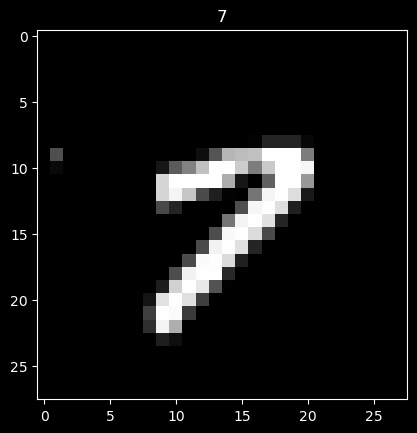

In [45]:
(X_treinamento, y_treinamento), (X_teste, y_teste) = mnist.load_data()
plt.imshow(X_treinamento[29], cmap="gray")
plt.title(y_treinamento[29])

In [46]:
X_treinamento = X_treinamento.reshape(
    (len(X_treinamento), np.prod(X_treinamento.shape[1:]))
)
X_teste = X_teste.reshape((len(X_teste), np.prod(X_teste.shape[1:])))

In [47]:
X_teste[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [48]:
X_treinamento = X_treinamento.astype("float32")
X_teste = X_teste.astype("float32")
X_treinamento /= 255
X_teste /= 255

In [49]:
y_treinamento = to_categorical(y_treinamento, 10)
y_teste = to_categorical(y_teste, 10)

In [50]:
y_teste[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [51]:
def treina_dl(n_camadas_ocultas, n_units, activation, drop_out, epochs):
    mlflow.set_experiment("DLExperimento")

    with mlflow.start_run():
        mlflow.tensorflow.autolog()

        # registro de tags
        mlflow.set_tag("n_camadas_ocultas", n_camadas_ocultas)
        mlflow.set_tag("n_units", n_units)
        mlflow.set_tag("activation", activation)
        mlflow.set_tag("drop_out", drop_out)
        mlflow.set_tag("epochs", epochs)

        modelo = Sequential()

        # cria camada oculta mais camada de entrada
        modelo.add(Dense(units=n_units, activation=activation, input_dim=784))
        modelo.add(Dropout(drop_out))

        # camadas ocultas adicionais, com drop out
        for n in range(n_camadas_ocultas):
            modelo.add(Dense(units=n_units, activation=activation))
            modelo.add(Dropout(drop_out))

        # camada de saída
        modelo.add(Dense(units=10, activation="softmax"))

        modelo.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

        modelo.summary()

        historico = modelo.fit(
            X_treinamento,
            y_treinamento,
            epochs=epochs,
            validation_data=(X_teste, y_teste),
        )

        # grafico para erros e acuracia
        historico.history.keys()
        loss = plt.plot(historico.history["val_loss"])
        plt.savefig("loss.png")
        acuracia = plt.plot(historico.history["val_accuracy"])
        plt.savefig("acuracia.png")

        # registrar artefatos
        mlflow.log_artifact("loss.png")
        mlflow.log_artifact("acuracia.png")

        # informações de execução
        print("Modelo: ", mlflow.active_run().info.run_uuid)
    mlflow.end_run()

In [52]:
n_camadas_ocultas = [1, 2, 3]
n_units = [16, 32, 64]
activation = ["relu", "tanh"]
drop_out = [0.1, 0.2]
epochs = [5, 10, 20]

for camadas in n_camadas_ocultas:
    for unidades in n_units:
        for ativacao in activation:
            for drop in drop_out:
                for epocas in epochs:
                    treina_dl(camadas, unidades, ativacao, drop, epocas)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 16)                12560     
                                                                 
 dropout_58 (Dropout)        (None, 16)                0         
                                                                 
 dense_88 (Dense)            (None, 16)                272       
                                                                 
 dropout_59 (Dropout)        (None, 16)                0         
                                                                 
 dense_89 (Dense)            (None, 10)                170       
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
   1/18

1875/1875 [==============================] - 5s 2ms/step - loss: 0.6663 - accuracy: 0.7886 - val_loss: 0.2774 - val_accuracy: 0.9200
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4051 - accuracy: 0.8752 - val_loss: 0.2215 - val_accuracy: 0.9352
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3528 - accuracy: 0.8909 - val_loss: 0.2045 - val_accuracy: 0.9387
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3292 - accuracy: 0.8983 - val_loss: 0.1979 - val_accuracy: 0.9406
Epoch 5/5
1/1 [==============================] - 0s 54ms/step
INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmpkpbooa32\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmpkpbooa32\model\data\model\assets


Modelo:  f449afac50234bb5bb9e685db4ee5140
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 16)                12560     
                                                                 
 dropout_60 (Dropout)        (None, 16)                0         
                                                                 
 dense_91 (Dense)            (None, 16)                272       
                                                                 
 dropout_61 (Dropout)        (None, 16)                0         
                                                                 
 dense_92 (Dense)            (None, 10)                170       
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

1875/1875 [==============================] - 4s 2ms/step - loss: 0.7035 - accuracy: 0.7733 - val_loss: 0.2862 - val_accuracy: 0.9185
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4071 - accuracy: 0.8736 - val_loss: 0.2375 - val_accuracy: 0.9289
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3594 - accuracy: 0.8881 - val_loss: 0.2178 - val_accuracy: 0.9344
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3280 - accuracy: 0.8987 - val_loss: 0.2093 - val_accuracy: 0.9388
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3113 - accuracy: 0.9040 - val_loss: 0.1928 - val_accuracy: 0.9424
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2996 - accuracy: 0.9082 - val_loss: 0.1867 - val_accuracy: 0.9428
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2857 - accuracy: 0.9132 - val_loss: 0.1850 - val_accuracy: 0.9441
Epo

INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmphaa4q7fs\model\data\model\assets


Modelo:  50f893f11d2a4258bb410b536ac479f5
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 16)                12560     
                                                                 
 dropout_62 (Dropout)        (None, 16)                0         
                                                                 
 dense_94 (Dense)            (None, 16)                272       
                                                                 
 dropout_63 (Dropout)        (None, 16)                0         
                                                                 
 dense_95 (Dense)            (None, 10)                170       
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

1875/1875 [==============================] - 4s 2ms/step - loss: 0.7483 - accuracy: 0.7599 - val_loss: 0.3190 - val_accuracy: 0.9083
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4601 - accuracy: 0.8579 - val_loss: 0.2791 - val_accuracy: 0.9193
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4008 - accuracy: 0.8780 - val_loss: 0.2542 - val_accuracy: 0.9250
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3714 - accuracy: 0.8867 - val_loss: 0.2319 - val_accuracy: 0.9316
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3538 - accuracy: 0.8929 - val_loss: 0.2305 - val_accuracy: 0.9345
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3434 - accuracy: 0.8967 - val_loss: 0.2297 - val_accuracy: 0.9315
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3325 - accuracy: 0.8998 - val_loss: 0.2235 - val_accuracy: 0.9355
Epo

INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmpdli1dkzl\model\data\model\assets


Modelo:  d3d8afddd3184a768a8af4c7e753f053
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 16)                12560     
                                                                 
 dropout_64 (Dropout)        (None, 16)                0         
                                                                 
 dense_97 (Dense)            (None, 16)                272       
                                                                 
 dropout_65 (Dropout)        (None, 16)                0         
                                                                 
 dense_98 (Dense)            (None, 10)                170       
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

1875/1875 [==============================] - 4s 2ms/step - loss: 0.8692 - accuracy: 0.7096 - val_loss: 0.3369 - val_accuracy: 0.9008
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5767 - accuracy: 0.8167 - val_loss: 0.2953 - val_accuracy: 0.9144
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5234 - accuracy: 0.8361 - val_loss: 0.2652 - val_accuracy: 0.9231
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4991 - accuracy: 0.8440 - val_loss: 0.2579 - val_accuracy: 0.9243
Epoch 5/5
1/1 [==============================] - 0s 48ms/step
INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmpq4zxy_wb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmpq4zxy_wb\model\data\model\assets


Modelo:  53bb1f5d9faf4207a64c9cb94f2d9f15
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 16)                12560     
                                                                 
 dropout_66 (Dropout)        (None, 16)                0         
                                                                 
 dense_100 (Dense)           (None, 16)                272       
                                                                 
 dropout_67 (Dropout)        (None, 16)                0         
                                                                 
 dense_101 (Dense)           (None, 10)                170       
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

1875/1875 [==============================] - 4s 2ms/step - loss: 0.8874 - accuracy: 0.7028 - val_loss: 0.3277 - val_accuracy: 0.9100
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5863 - accuracy: 0.8155 - val_loss: 0.2781 - val_accuracy: 0.9174
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5324 - accuracy: 0.8354 - val_loss: 0.2660 - val_accuracy: 0.9220
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5012 - accuracy: 0.8438 - val_loss: 0.2435 - val_accuracy: 0.9296
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4878 - accuracy: 0.8496 - val_loss: 0.2460 - val_accuracy: 0.9293
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4754 - accuracy: 0.8536 - val_loss: 0.2342 - val_accuracy: 0.9296
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4595 - accuracy: 0.8598 - val_loss: 0.2343 - val_accuracy: 0.9330
Epo

INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmp6m92td2d\model\data\model\assets


Modelo:  515af71e3a544496a3c8c6948290a118
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 16)                12560     
                                                                 
 dropout_68 (Dropout)        (None, 16)                0         
                                                                 
 dense_103 (Dense)           (None, 16)                272       
                                                                 
 dropout_69 (Dropout)        (None, 16)                0         
                                                                 
 dense_104 (Dense)           (None, 10)                170       
                                                                 
Total params: 13002 (50.79 KB)
Trainable params: 13002 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

1875/1875 [==============================] - 4s 2ms/step - loss: 0.8981 - accuracy: 0.6998 - val_loss: 0.3451 - val_accuracy: 0.9054
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5924 - accuracy: 0.8114 - val_loss: 0.2721 - val_accuracy: 0.9207
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5286 - accuracy: 0.8348 - val_loss: 0.2543 - val_accuracy: 0.9278
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4973 - accuracy: 0.8456 - val_loss: 0.2424 - val_accuracy: 0.9277
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4673 - accuracy: 0.8568 - val_loss: 0.2340 - val_accuracy: 0.9314
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4512 - accuracy: 0.8605 - val_loss: 0.2238 - val_accuracy: 0.9330
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4404 - accuracy: 0.8645 - val_loss: 0.2243 - val_accuracy: 0.9363
Epo

INFO:tensorflow:Assets written to: C:\Users\carlo\AppData\Local\Temp\tmphe1b0jov\model\data\model\assets
